# Read alto

In [139]:
from typing import Dict, List, Tuple
from collections import namedtuple, defaultdict
import lxml.etree as et
import os

class NoSourceImage(Exception):
    """ Raised when the ALTO is missing a link to an image file """

BBOX = namedtuple("Bbox", ["x1", "y1", "x2", "y2", "file", "id", "image"])
NS = {"a": "http://www.loc.gov/standards/alto/ns-v2#"}

def temporary_replace_path(xml_path):
    return f"../IMG/{xml_path.replace('.xml', '.jpg')}"

def read_alto(alto_xml) -> Tuple[Dict[str, List[BBOX]], str]:
    classes = defaultdict(list)
    
    with open(alto_xml) as f:
        xml = et.parse(f)
        source_image = xml.xpath("//a:sourceImageInformation/a:fileName/text()", namespaces=NS)
        if not len(source_image):
            raise NoSourceImage(f"{alto_xml} is missing the following node"
                                "`/alto/Description/sourceImageInformation/fileName`"
                               "which should contain the path to the image it is about")
        source_image = temporary_replace_path(source_image[0])
        real_path = os.path.abspath(
            os.path.join(os.path.dirname(alto_xml), source_image)
        )
        if not os.path.isfile(real_path):
            raise NoSourceImage(f"{alto_xml} has a wrong path at"
                                "`/alto/Description/sourceImageInformation/fileName`"
                               f": {real_path}")
        
        styles = {
            style.attrib["ID"]: style.attrib["FONTSTYLE"] if style.attrib["FONTSTYLE"] else "_"
            for style in xml.xpath("//a:TextStyle", namespaces=NS)
        }
        for string in xml.xpath("//a:String", namespaces=NS):
            x, y, = string.attrib["HPOS"], string.attrib["VPOS"]
            w, h = string.attrib["WIDTH"], string.attrib["HEIGHT"]
            x, y, w, h = float(x), float(y), float(w), float(h)
            style = styles[string.attrib["STYLEREFS"]]
            classes[style].append(BBOX(x, y, x+w, y+h, alto_xml, 
                                       string.attrib["ID"], real_path))
            
    return classes, real_path

import glob

data = defaultdict(list)
for xml_path in glob.glob("./input/*/ALTO/*.xml"):
    current, image = read_alto(xml_path)
    for key in current:
        data[key].extend(current[key])
    
minimum = float("inf")
for cls in data:
    total = sum([len(val) for val in data.values()])
    print(f"{cls.zfill(10).replace('0', ' ')} : {len(data[cls])/total:.2f} of the whole ({len(data[cls])})")
    minimum = min([len(data[cls]), minimum])
print(minimum)

         _ : 0.91 of the whole (38663)
   italics : 0.04 of the whole (1731)
      bold : 0.05 of the whole (1928)
1731


# Extract images

In [140]:
import os
from IPython.display import display
import PIL.Image as PILImage
#import tqdm.tqdm

output_dir = "./data/"
os.makedirs(output_dir, exist_ok=True)

    
source = PILImage.open(image)
for cls, items in data.items():
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)
    for id_, bbox in enumerate(items):
        area = source.crop(bbox[:4])
        area.save(
            os.path.join(
                output_dir,
                cls,
                f"{os.path.basename(bbox.image)}.{id_}.png"
            )
        ) 

# Split and generate test dataset

In [141]:
import random
test_dir = "./test_data"
os.makedirs(test_dir, exist_ok=True)

for cls in glob.glob("./data/*"):
    files = glob.glob(os.path.join(cls, "*.png"))
    random.shuffle(files)
    os.makedirs(cls.replace("data", "test_data"), exist_ok=True)
    for file in files[:int(minimum*0.1)]:
        os.rename(file, file.replace("data", "test_data"))
        
train_dir = "./train_data"
os.makedirs(train_dir, exist_ok=True)

for cls in glob.glob("./data/*"):
    files = glob.glob(os.path.join(cls, "*.png"))
    random.shuffle(files)
    os.makedirs(cls.replace("data", train_dir), exist_ok=True)
    for file in files[:minimum]:
        os.rename(file, file.replace("data", train_dir))

# Create dataset

In [142]:
import torchvision
import torchvision.transforms as transforms
import torch.utils.data

pre_process = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

trainset = torchvision.datasets.ImageFolder(
    train_dir,
    transform=pre_process
)
testset = torchvision.datasets.ImageFolder(
    test_dir,
    transform=pre_process
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4,
    shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4,
    shuffle=True, num_workers=2
)
classes = {n: key for n, key in enumerate(dataset.classes)}

# Visualize sample

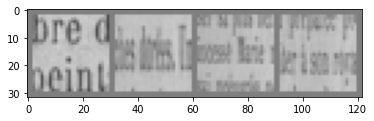

Classes bold italics  bold  bold


In [143]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Classes" + ' '.join('%5s' % classes[labels[j].tolist()] for j in range(4)))

# Count classes in test set

In [144]:
# get some random training images
from collections import Counter

dataiter = iter(testloader)

out = []
for images, labels in dataiter:
    out.extend([classes[labels[j].tolist()] for j in range(len(labels))])
    
print(Counter(out))

Counter({'bold': 173, 'italics': 173, '_': 173})


In [145]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, classes: int):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv1_drop = nn.Dropout2d()
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [146]:
# https://nextjournal.com/gkoehler/pytorch-mnist
import torch.optim as optim

n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1

network = Net(len(classes))
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [147]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]

In [148]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(trainloader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(trainloader.dataset),
        100. * batch_idx / len(trainloader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [149]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in testloader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(testloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))

In [150]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/home/thibault/dev/alto-fontstyle-classifier/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/thibault/dev/alto-fontstyle-classifier/env/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0991, Accuracy: 174/519 (34%)

Train Epoch: 1 [0/5020 (0%)]	Loss: 1.130505
Train Epoch: 1 [40/5020 (1%)]	Loss: 1.167869
Train Epoch: 1 [80/5020 (2%)]	Loss: 1.111868
Train Epoch: 1 [120/5020 (2%)]	Loss: 1.105965
Train Epoch: 1 [160/5020 (3%)]	Loss: 1.142885
Train Epoch: 1 [200/5020 (4%)]	Loss: 1.134617
Train Epoch: 1 [240/5020 (5%)]	Loss: 1.038367
Train Epoch: 1 [280/5020 (6%)]	Loss: 1.086922
Train Epoch: 1 [320/5020 (6%)]	Loss: 1.058128
Train Epoch: 1 [360/5020 (7%)]	Loss: 1.102284
Train Epoch: 1 [400/5020 (8%)]	Loss: 1.104639
Train Epoch: 1 [440/5020 (9%)]	Loss: 1.108813
Train Epoch: 1 [480/5020 (10%)]	Loss: 1.133524
Train Epoch: 1 [520/5020 (10%)]	Loss: 1.020472
Train Epoch: 1 [560/5020 (11%)]	Loss: 1.113517
Train Epoch: 1 [600/5020 (12%)]	Loss: 1.094149
Train Epoch: 1 [640/5020 (13%)]	Loss: 1.118983
Train Epoch: 1 [680/5020 (14%)]	Loss: 1.080164
Train Epoch: 1 [720/5020 (14%)]	Loss: 1.113295
Train Epoch: 1 [760/5020 (15%)]	Loss: 1.090271
Train Epoch: 1 [800/5

Train Epoch: 2 [1920/5020 (38%)]	Loss: 1.052822
Train Epoch: 2 [1960/5020 (39%)]	Loss: 1.116410
Train Epoch: 2 [2000/5020 (40%)]	Loss: 1.054382
Train Epoch: 2 [2040/5020 (41%)]	Loss: 1.088969
Train Epoch: 2 [2080/5020 (41%)]	Loss: 1.067372
Train Epoch: 2 [2120/5020 (42%)]	Loss: 1.052779
Train Epoch: 2 [2160/5020 (43%)]	Loss: 1.077110
Train Epoch: 2 [2200/5020 (44%)]	Loss: 1.139269
Train Epoch: 2 [2240/5020 (45%)]	Loss: 1.091914
Train Epoch: 2 [2280/5020 (45%)]	Loss: 1.073414
Train Epoch: 2 [2320/5020 (46%)]	Loss: 1.150339
Train Epoch: 2 [2360/5020 (47%)]	Loss: 1.101429
Train Epoch: 2 [2400/5020 (48%)]	Loss: 1.083692
Train Epoch: 2 [2440/5020 (49%)]	Loss: 1.071304
Train Epoch: 2 [2480/5020 (49%)]	Loss: 1.121988
Train Epoch: 2 [2520/5020 (50%)]	Loss: 1.005033
Train Epoch: 2 [2560/5020 (51%)]	Loss: 1.120510
Train Epoch: 2 [2600/5020 (52%)]	Loss: 0.990209
Train Epoch: 2 [2640/5020 (53%)]	Loss: 1.086406
Train Epoch: 2 [2680/5020 (53%)]	Loss: 1.079069
Train Epoch: 2 [2720/5020 (54%)]	Loss: 1

Train Epoch: 3 [3760/5020 (75%)]	Loss: 1.030753
Train Epoch: 3 [3800/5020 (76%)]	Loss: 1.123324
Train Epoch: 3 [3840/5020 (76%)]	Loss: 1.122419
Train Epoch: 3 [3880/5020 (77%)]	Loss: 1.127764
Train Epoch: 3 [3920/5020 (78%)]	Loss: 1.072102
Train Epoch: 3 [3960/5020 (79%)]	Loss: 1.016986
Train Epoch: 3 [4000/5020 (80%)]	Loss: 1.027104
Train Epoch: 3 [4040/5020 (80%)]	Loss: 1.082389
Train Epoch: 3 [4080/5020 (81%)]	Loss: 1.064517
Train Epoch: 3 [4120/5020 (82%)]	Loss: 1.124285
Train Epoch: 3 [4160/5020 (83%)]	Loss: 1.160861
Train Epoch: 3 [4200/5020 (84%)]	Loss: 0.991466
Train Epoch: 3 [4240/5020 (84%)]	Loss: 1.103919
Train Epoch: 3 [4280/5020 (85%)]	Loss: 1.116560
Train Epoch: 3 [4320/5020 (86%)]	Loss: 1.016010
Train Epoch: 3 [4360/5020 (87%)]	Loss: 0.984327
Train Epoch: 3 [4400/5020 (88%)]	Loss: 1.063717
Train Epoch: 3 [4440/5020 (88%)]	Loss: 1.075110
Train Epoch: 3 [4480/5020 (89%)]	Loss: 1.080029
Train Epoch: 3 [4520/5020 (90%)]	Loss: 1.324852
Train Epoch: 3 [4560/5020 (91%)]	Loss: 1

Train Epoch: 5 [480/5020 (10%)]	Loss: 0.868047
Train Epoch: 5 [520/5020 (10%)]	Loss: 0.853139
Train Epoch: 5 [560/5020 (11%)]	Loss: 1.161170
Train Epoch: 5 [600/5020 (12%)]	Loss: 1.079843
Train Epoch: 5 [640/5020 (13%)]	Loss: 1.047363
Train Epoch: 5 [680/5020 (14%)]	Loss: 1.083632
Train Epoch: 5 [720/5020 (14%)]	Loss: 1.130281
Train Epoch: 5 [760/5020 (15%)]	Loss: 0.912790
Train Epoch: 5 [800/5020 (16%)]	Loss: 0.995339
Train Epoch: 5 [840/5020 (17%)]	Loss: 1.185047
Train Epoch: 5 [880/5020 (18%)]	Loss: 0.926134
Train Epoch: 5 [920/5020 (18%)]	Loss: 1.228569
Train Epoch: 5 [960/5020 (19%)]	Loss: 1.088405
Train Epoch: 5 [1000/5020 (20%)]	Loss: 0.941848
Train Epoch: 5 [1040/5020 (21%)]	Loss: 1.170000
Train Epoch: 5 [1080/5020 (22%)]	Loss: 1.241540
Train Epoch: 5 [1120/5020 (22%)]	Loss: 1.115193
Train Epoch: 5 [1160/5020 (23%)]	Loss: 1.075621
Train Epoch: 5 [1200/5020 (24%)]	Loss: 1.091353
Train Epoch: 5 [1240/5020 (25%)]	Loss: 1.156552
Train Epoch: 5 [1280/5020 (25%)]	Loss: 1.062790
Train

Train Epoch: 6 [2400/5020 (48%)]	Loss: 0.991801
Train Epoch: 6 [2440/5020 (49%)]	Loss: 1.492308
Train Epoch: 6 [2480/5020 (49%)]	Loss: 1.122936
Train Epoch: 6 [2520/5020 (50%)]	Loss: 0.937307
Train Epoch: 6 [2560/5020 (51%)]	Loss: 1.027027
Train Epoch: 6 [2600/5020 (52%)]	Loss: 0.942068
Train Epoch: 6 [2640/5020 (53%)]	Loss: 0.769258
Train Epoch: 6 [2680/5020 (53%)]	Loss: 1.369637
Train Epoch: 6 [2720/5020 (54%)]	Loss: 1.005214
Train Epoch: 6 [2760/5020 (55%)]	Loss: 1.116015
Train Epoch: 6 [2800/5020 (56%)]	Loss: 1.093661
Train Epoch: 6 [2840/5020 (57%)]	Loss: 0.906093
Train Epoch: 6 [2880/5020 (57%)]	Loss: 1.184712
Train Epoch: 6 [2920/5020 (58%)]	Loss: 0.627637
Train Epoch: 6 [2960/5020 (59%)]	Loss: 1.024780
Train Epoch: 6 [3000/5020 (60%)]	Loss: 1.037341
Train Epoch: 6 [3040/5020 (61%)]	Loss: 1.175680
Train Epoch: 6 [3080/5020 (61%)]	Loss: 1.635156
Train Epoch: 6 [3120/5020 (62%)]	Loss: 1.087824
Train Epoch: 6 [3160/5020 (63%)]	Loss: 1.188849
Train Epoch: 6 [3200/5020 (64%)]	Loss: 0

Train Epoch: 7 [4360/5020 (87%)]	Loss: 1.148820
Train Epoch: 7 [4400/5020 (88%)]	Loss: 1.149477
Train Epoch: 7 [4440/5020 (88%)]	Loss: 1.433845
Train Epoch: 7 [4480/5020 (89%)]	Loss: 1.066870
Train Epoch: 7 [4520/5020 (90%)]	Loss: 0.959706
Train Epoch: 7 [4560/5020 (91%)]	Loss: 1.049703
Train Epoch: 7 [4600/5020 (92%)]	Loss: 0.943441
Train Epoch: 7 [4640/5020 (92%)]	Loss: 0.980943
Train Epoch: 7 [4680/5020 (93%)]	Loss: 0.942707
Train Epoch: 7 [4720/5020 (94%)]	Loss: 1.314946
Train Epoch: 7 [4760/5020 (95%)]	Loss: 1.233408
Train Epoch: 7 [4800/5020 (96%)]	Loss: 0.893873
Train Epoch: 7 [4840/5020 (96%)]	Loss: 0.896520
Train Epoch: 7 [4880/5020 (97%)]	Loss: 1.060878
Train Epoch: 7 [4920/5020 (98%)]	Loss: 1.165703
Train Epoch: 7 [4960/5020 (99%)]	Loss: 0.803354
Train Epoch: 7 [5000/5020 (100%)]	Loss: 1.239305

Test set: Avg. loss: 1.0295, Accuracy: 247/519 (48%)

Train Epoch: 8 [0/5020 (0%)]	Loss: 1.631819
Train Epoch: 8 [40/5020 (1%)]	Loss: 0.988949
Train Epoch: 8 [80/5020 (2%)]	Loss: 1.0

Train Epoch: 9 [1120/5020 (22%)]	Loss: 1.077276
Train Epoch: 9 [1160/5020 (23%)]	Loss: 0.940240
Train Epoch: 9 [1200/5020 (24%)]	Loss: 1.215696
Train Epoch: 9 [1240/5020 (25%)]	Loss: 0.737921
Train Epoch: 9 [1280/5020 (25%)]	Loss: 1.059930
Train Epoch: 9 [1320/5020 (26%)]	Loss: 1.081724
Train Epoch: 9 [1360/5020 (27%)]	Loss: 0.952554
Train Epoch: 9 [1400/5020 (28%)]	Loss: 0.899455
Train Epoch: 9 [1440/5020 (29%)]	Loss: 0.959901
Train Epoch: 9 [1480/5020 (29%)]	Loss: 0.965587
Train Epoch: 9 [1520/5020 (30%)]	Loss: 0.927807
Train Epoch: 9 [1560/5020 (31%)]	Loss: 1.171038
Train Epoch: 9 [1600/5020 (32%)]	Loss: 0.934932
Train Epoch: 9 [1640/5020 (33%)]	Loss: 1.136378
Train Epoch: 9 [1680/5020 (33%)]	Loss: 1.090138
Train Epoch: 9 [1720/5020 (34%)]	Loss: 0.895982
Train Epoch: 9 [1760/5020 (35%)]	Loss: 1.264411
Train Epoch: 9 [1800/5020 (36%)]	Loss: 1.105759
Train Epoch: 9 [1840/5020 (37%)]	Loss: 1.035390
Train Epoch: 9 [1880/5020 (37%)]	Loss: 1.229943
Train Epoch: 9 [1920/5020 (38%)]	Loss: 1

Train Epoch: 10 [2880/5020 (57%)]	Loss: 0.909784
Train Epoch: 10 [2920/5020 (58%)]	Loss: 1.085249
Train Epoch: 10 [2960/5020 (59%)]	Loss: 0.833710
Train Epoch: 10 [3000/5020 (60%)]	Loss: 1.032132
Train Epoch: 10 [3040/5020 (61%)]	Loss: 1.064322
Train Epoch: 10 [3080/5020 (61%)]	Loss: 0.827934
Train Epoch: 10 [3120/5020 (62%)]	Loss: 1.363022
Train Epoch: 10 [3160/5020 (63%)]	Loss: 1.155865
Train Epoch: 10 [3200/5020 (64%)]	Loss: 0.911495
Train Epoch: 10 [3240/5020 (65%)]	Loss: 0.947805
Train Epoch: 10 [3280/5020 (65%)]	Loss: 0.825354
Train Epoch: 10 [3320/5020 (66%)]	Loss: 0.901036
Train Epoch: 10 [3360/5020 (67%)]	Loss: 0.873560
Train Epoch: 10 [3400/5020 (68%)]	Loss: 1.046563
Train Epoch: 10 [3440/5020 (69%)]	Loss: 1.008747
Train Epoch: 10 [3480/5020 (69%)]	Loss: 0.917340
Train Epoch: 10 [3520/5020 (70%)]	Loss: 0.981159
Train Epoch: 10 [3560/5020 (71%)]	Loss: 0.813661
Train Epoch: 10 [3600/5020 (72%)]	Loss: 1.278916
Train Epoch: 10 [3640/5020 (73%)]	Loss: 1.020098
Train Epoch: 10 [368